## Question: If corpus A & B are shuffled together into C, how are their growth curves related?

A quick thought experiment will do here: Obviously $M_C = M_A + M_B$, that is straightforward enough. But $N_C = |A ∪ B| = |A| + |B| - |A ∩ B| = N_A + N_B - x$. What exactly is $x$? How many words do the corpi share in common? Are they disjoint (i.e. $x = 0$)? Are they _the same corpus_ (i.e. $x = N_A = N_B$)? Clearly, there are hidden factors buried in the properties of the corpi themselves.

- As a first pass, is there _any_ way to estimate $N_C = f(M_A, N_A, M_B, N_B)$ with no extra information?
- What features of A & B are necessary to improve (or perfect) this relation?
- How does multi-channel mixing impact the performance of the logarithmic model? (cross-author, cross-subject, cross-language, etc)

In [1]:
# bloody dependencies
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 8)
from nltk.corpus import gutenberg
import numpy as np
import pandas as pd

# custom classes
from legomena import Corpus, SPGC, LogModel

In [2]:
# standard project gutenberg corpus
spgc = SPGC.getMeta()

# for now, restrict study to english-only
spgc = spgc[spgc.language == "['en']"]

# preview
spgc.head()

,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type
id,,,,,,,,
1,The Declaration of Independence of the United ...,"Jefferson, Thomas",1743.0,1826.0,['en'],604.0,"{'United States -- History -- Revolution, 1775...",Text
2,The United States Bill of Rights: The Ten Orig...,United States,NaN,NaN,['en'],158.0,"{'Civil rights -- United States -- Sources', '...",Text
3,John F. Kennedy's Inaugural Address,"Kennedy, John F. (John Fitzgerald)",1917.0,1963.0,['en'],28.0,{'Presidents -- United States -- Inaugural add...,Text
4,Lincoln's Gettysburg Address: Given November 1...,"Lincoln, Abraham",1809.0,1865.0,['en'],55.0,{'Consecration of cemeteries -- Pennsylvania -...,Text
5,The United States Constitution,United States,NaN,NaN,['en'],226.0,"{'United States. Constitution', 'United States...",Text


In [3]:
# all melville's work
melville = spgc[spgc.author == "Melville, Herman"]
melville.sort_values("downloads").tail()

,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type
id,,,,,,,,
2489,"Moby Dick; Or, The Whale","Melville, Herman",1819.0,1891.0,['en'],324.0,"{'Mentally ill -- Fiction', 'Whaling ships -- ...",Text
21816,The Confidence-Man: His Masquerade,"Melville, Herman",1819.0,1891.0,['en'],518.0,"{'Satire', 'Swindlers and swindling -- Fiction...",Text
11231,"Bartleby, the Scrivener: A Story of Wall-Street","Melville, Herman",1819.0,1891.0,['en'],740.0,"{'Young men -- Fiction', 'Copyists -- Fiction'...",Text
15,Moby Dick,"Melville, Herman",1819.0,1891.0,['en'],905.0,"{'Mentally ill -- Fiction', 'Whaling ships -- ...",Text
2701,"Moby Dick; Or, The Whale","Melville, Herman",1819.0,1891.0,['en'],14337.0,"{'Whaling ships -- Fiction', 'Mentally ill -- ...",Text


In [4]:
# moby dick
mobydick = SPGC.get(2701)

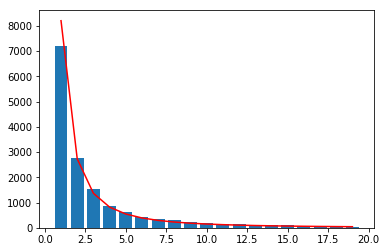

In [5]:
# k-legomena distributions
x = np.arange(1, 20)
plt.bar(x, mobydick.k[x])
plt.plot(x, mobydick.N/x/(x+1), color="r")
plt.show()

In [6]:
# load all melville into memory
corpi, models = {}, {}
for pgid in melville.index.values:
    corpus = SPGC.get(pgid)
    if corpus is None:
        continue
    df = corpus.TTR # empirical TTR: 100 samples
    m_tokens, n_types = df.m_tokens, df.n_types
    model = LogModel()
    model.fit(m_tokens, n_types) # best fit logarithmic model: M_z,N_z
    corpi[pgid] = corpus
    models[pgid] = model

In [7]:
# tabulate (M,N,k1) for all of melville
keys = melville.index.values
items = zip(corpi.values(), models.values())
df = [ (pgid, corpus.M, corpus.N, model.M_z, model.N_z, corpus.k[1]) for pgid, (corpus, model) in zip(keys, items) ]
df = pd.DataFrame(df, columns = ["id", "m_tokens", "n_types", "M_z", "N_z", "hapaxes"])
df = df.set_index("id")
df

,m_tokens,n_types,M_z,N_z,hapaxes
id,,,,,
15,1352,595,42963,5295,448
1900,113161,10382,56073,7471,4518
2489,210370,16570,114901,12464,7278
2694,11276,2606,66944,7212,1686
2701,210258,16402,112328,12205,7197
4045,101290,10415,76584,9117,4767
8118,117072,10973,97633,10063,5152
10712,135918,12873,98595,11049,5856
11231,14293,2923,53086,6045,1782


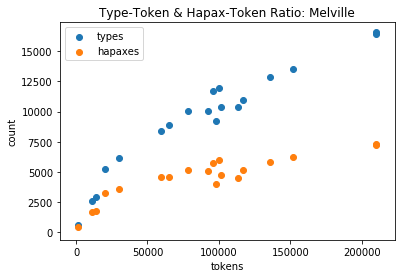

In [8]:
# draw a pretty picture
plt.scatter(df.m_tokens, df.n_types, label = "types")
plt.scatter(df.m_tokens, df.hapaxes, label = "hapaxes")
plt.title("Type-Token & Hapax-Token Ratio: Melville")
plt.xlabel("tokens")
plt.ylabel("count")
plt.legend()
plt.show()

In [9]:

pgids = ["4045", "1900", "8118", "2701"]
L = len(pgids)
N_mat = np.zeros((L, L))
for i,A in enumerate(pgids):
    for j,B in enumerate(pgids):
        corpusA = corpi[A]
        corpusB = corpi[B]
        tokensC = corpusA.tokens + corpusB.tokens
        corpusC = Corpus(tokensC)
        N_mat[i][j] = corpusC.N
        
N_mat

array([[10415., 14657., 15428., 19825.],
       [14657., 10382., 15658., 19704.],
       [15428., 15658., 10973., 20003.],
       [19825., 19704., 20003., 16402.]])

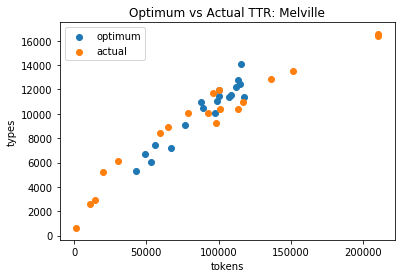

In [10]:
# optimum vs actual
plt.scatter(df.M_z, df.N_z, label = "optimum")
plt.scatter(df.m_tokens, df.n_types, label = "actual")
plt.title("Optimum vs Actual TTR: Melville")
plt.xlabel("tokens")
plt.ylabel("types")
plt.legend()
plt.show()

In [11]:
df["title"] = melville["title"]
df.sort_values("n_types")

,m_tokens,n_types,M_z,N_z,hapaxes,title
id,,,,,,
15,1352,595,42963,5295,448,Moby Dick
2694,11276,2606,66944,7212,1686,I and My Chimney
11231,14293,2923,53086,6045,1782,"Bartleby, the Scrivener: A Story of Wall-Street"
12841,20241,5226,115194,14109,3285,John Marr and Other Poems
12384,30158,6148,87768,11001,3570,Battle-Pieces and Aspects of the War
53861,59780,8418,106862,11415,4561,The Apple-Tree Table and Other Sketches
15422,64822,8897,88920,10482,4597,Israel Potter: His Fifty Years of Exile
28656,98129,9239,49388,6706,3992,Typee
21816,92717,10058,117564,11377,5080,The Confidence-Man: His Masquerade


In [12]:
# choose two books
corpusA  = corpi['28656']
corpusB  = corpi['8118']
corpusAB = Corpus(corpusA.tokens + corpusB.tokens)

# build TTR curves
dfA = corpusA.TTR
dfB = corpusB.TTR
dfAB = corpusAB.TTR

# initialize models
modelA = LogModel()
modelB = LogModel()
modelAB = LogModel()

# fit log function
modelA.fit(dfA.m_tokens, dfA.n_types)
modelB.fit(dfB.m_tokens, dfB.n_types)
modelAB.fit(dfAB.m_tokens, dfAB.n_types)

/home/victor/Documents/GitHub/legomena/legomena.py:339: RuntimeWarning: invalid value encountered in log
  func = lambda m, M_z, N_z: N_z * np.log(m / M_z) * m / M_z / (m / M_z - 1)


LogParams(M_z=78741, N_z=9426)

|A| = 9239
|B| = 10973
|A ∪ B| = 14911
|A ∩ B| = 5301


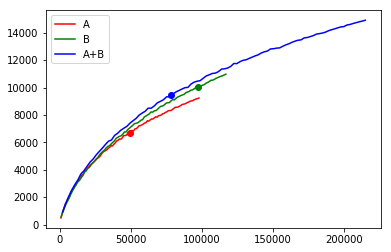

(M_z, N_z) = (49388, 6706)
(M_z, N_z) = (97633, 10063)
(M_z, N_z) = (78741, 9426)
A+B, theory: [75634.  8532.]


In [13]:
# venn diagram of types
A = set(corpusA.types)
B = set(corpusB.types)
print("|A| =", len(A))
print("|B| =", len(B))
print("|A ∪ B| =", len(A.union(B)))
print("|A ∩ B| =", len(A.intersection(B)))

# vectorize
A_  = np.array([ modelA.M_z, modelA.N_z ])
B_  = np.array([ modelB.M_z, modelB.N_z ])
AB_ = np.array([ modelAB.M_z, modelAB.N_z ])

# plot C=A+B
plt.plot(dfA.m_tokens, dfA.n_types, color = "r", label = "A")
plt.plot(dfB.m_tokens, dfB.n_types, color = "g", label = "B")
plt.plot(dfAB.m_tokens, dfAB.n_types, color = "b", label = "A+B")
plt.scatter([modelA.M_z], [modelA.N_z], color = "r")
plt.scatter([modelB.M_z], [modelB.N_z], color = "g")
plt.scatter([modelAB.M_z], [modelAB.N_z], color = "b")
plt.legend()
plt.show()

# combine
for model in [ modelA, modelB, modelAB ]:
    print("(M_z, N_z) =", (model.M_z, model.N_z))
    
AB_theory = np.round((corpusA.M * A_ + corpusB.M * B_) / corpusAB.M)
print("A+B, theory:", AB_theory)

In [14]:
print("A:", (modelA.M_z, modelA.N_z))
print("B:", (modelB.M_z, modelB.N_z))
print("A+B:", (modelAB.M_z, modelAB.N_z))

A: (49388, 6706)
B: (97633, 10063)
A+B: (78741, 9426)


## Halve the Corpus

In talking about an "optimum" sample size there is an implicit assumption that this is fixed. Yet the optimum values of $M_z, N_z$ clearly fall on a curve of some kind proportional to $M, N$. That is, a smaller corpus has a _relatively_ bigger optimum and a bigger corpus has a _relatively_ smaller one. Some mechanism is exerting "pressure" on $M, N$ _toward_ an optimum but it doesn't converge on a single point. That different _books_ would map map to their optima according to some pattern would be too noisy. Rather, we need to construct mini-corpi from the corpus in question to eliminate book-to-book variations as a factor.

Take the corpus, cut it in half, and refit the half-corpus. We hypothesized that $M_z', N_z'$ would be unchanged. After all, if that's the "optimum" for the whole corpus, it ought to be _the_ optimum. That's not the case. By _halving_ the corpus, we found $M_z', N_z'$ to _increase_ by roughly $5.5\%, 3\%$, respectively, with bootstrapping error bounds ruling out a fluke. So we changed the arbitrary "one half" to a uniform random variable between $[0.2, 0.8]$ and found the following strange relation.

In [18]:
# take a single book and cut it by 1/n. The values for (M',N') are predictable via the TTR curve, but what about (M_z', N_z')?
df = []
corpus = corpi["2701"]
model = LogModel()
m_tokens, n_types = TTR.m_tokens, TTR.n_types
model.fit(m_tokens, n_types)
M_z, N_z = model.params
for _ in range(9):
    half = int(np.random.uniform(0.2, 0.8) * corpus.M)
    halftokens = np.random.choice(corpus.tokens, half, replace = False)
    halfcorpus = Corpus(halftokens)
    TTR = halfcorpus.TTR
    model = LogModel()
    m_tokens, n_types = TTR.m_tokens, TTR.n_types
    model.fit(m_tokens, n_types)
    df.append((half, model.M_z, model.N_z))

df = pd.DataFrame(df, columns = ["x", "M_z", "N_z"])
df.sort_values("x", inplace = True)
df["M_z_"] = df.M_z / model.M_z
df["N_z_"] = df.N_z / model.N_z
df["x_"] = df.x / corpus.M
df

,x,M_z,N_z,M_z_,N_z_,x_
6,43891,116677,12405,0.915588,0.945503,0.208748
8,57880,127434,13120,1.000000,1.000000,0.275281
0,72199,123627,12919,0.970126,0.984680,0.343383
3,81248,124003,12951,0.973076,0.987119,0.386420
4,88475,126662,13058,0.993942,0.995274,0.420793
7,90082,122524,12820,0.961470,0.977134,0.428436
5,110841,122157,12808,0.958590,0.976220,0.527167
2,118966,116904,12476,0.917369,0.950915,0.565810
1,121544,114647,12272,0.899658,0.935366,0.578071


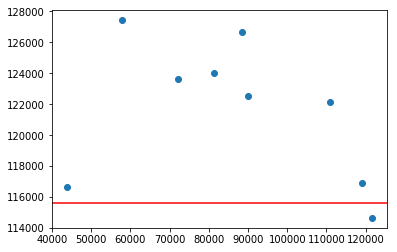

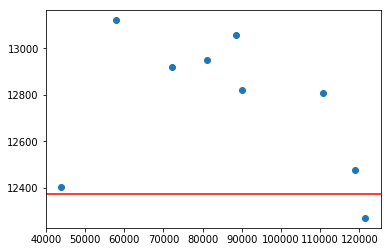

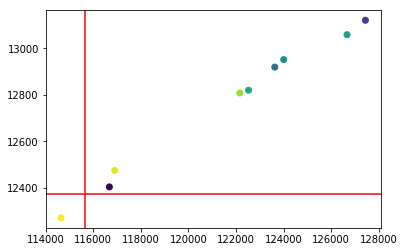

In [19]:
plt.scatter(df.x, df.M_z)
plt.axhline(y = M_z, color = "red")
plt.show()
plt.scatter(df.x, df.N_z)
plt.axhline(y = N_z, color = "red")
plt.show()
plt.scatter(df.M_z, df.N_z, c = df.x)
plt.axvline(x = M_z, color = "red")
plt.axhline(y = N_z, color = "red")
plt.show()

M_z'/M_z = 1.056374202251855 +/- nan
N_z'/N_z = 1.0350735412962664 +/- nan


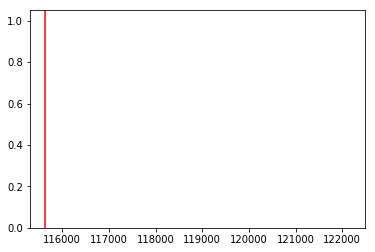

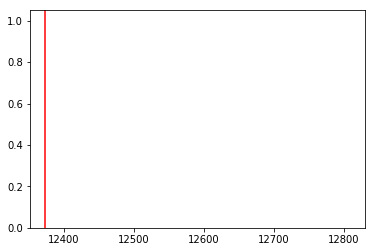

In [20]:
df = df[df.x_ > 0.47]
df = df[df.x_ < 0.53]
print("M_z'/M_z = %s +/- %s" % ((df.M_z / M_z).mean(), (df.M_z / M_z).std()))
print("N_z'/N_z = %s +/- %s" % ((df.N_z / N_z).mean(), (df.N_z / N_z).std()))

plt.hist(df.M_z); plt.axvline(x = M_z, color = "red"); plt.show()
plt.hist(df.N_z); plt.axvline(x = N_z, color = "red"); plt.show()

## What does it mean?

We are at a total loss to explain, or even describe this. Clearly, the optimum sample size varies as a function of the _absolute_ sample size, in total contradiction to the notion of $M_z, N_z$ being model parameters at all. They are parameters _at this sample size_, but drift when over- or under-sampling.

Hypothesis: The estimate $E(\frac{1}{2}M) = N_z\frac{\ln(1/2)}{4}$ includes some probability of drawing _every_ hapax into the sample. However, once we've _taken_ the sample and start sampling from the _sample_, the chance of drawing some hapax from the _original_ corpus _not_ drawn by the first sample is zero. We can show this visually as follows. _Partition_ the corpus into halves. Plot the TTR curve of each and notice that the two values of $M_z', N_z'$ are roughly the same, but that each sub-TTR curve is higher than the composite.

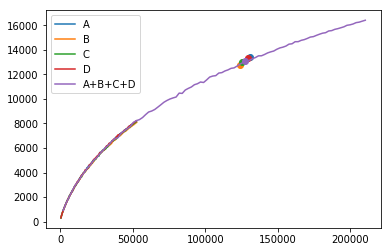

In [25]:
# partition the corpus
partitions = ["A", "B", "C", "D"]
partition = np.random.choice(partitions, size=corpus.M)
for i in partitions:
    corpus_ = Corpus(tokens[partition == i])
    model_ = LogModel()
    model_.fit(corpus_.TTR.m_tokens, corpus_.TTR.n_types)
    plt.plot(corpus_.TTR.m_tokens, corpus_.TTR.n_types, label = i)
    plt.scatter([model_.M_z], [model_.N_z])

# plot C=A+B
plt.plot(corpus.TTR.m_tokens,  corpus.TTR.n_types, label = "+".join(partitions))
plt.scatter([model.M_z],  [model.N_z])
plt.legend()
plt.show()